In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calibration

In [26]:
cal = pd.read_csv("scope_0.csv", header=1)
cal.columns=["x-axis", "1", "2"]

# Conversion factor k = -1/R
R_ = np.average(cal["2"])/np.average(cal["1"]) * 11.99e3
K_ = -1/R_

avg1 = np.average(cal["1"])
std1 = np.std(cal["1"])

avg2 = np.average(cal["2"])
std2 = np.std(cal["2"])

# New standard deviation calculation

In [24]:
#let us define the ingredients
v0 = avg1
vout = avg2
R0 = 11.99e3

s_v0 = std1
s_vout = std2
s_R0 = 0.01e3

#relative standard deviations
rel_s_v0 = s_v0 / v0
rel_s_vout = s_vout / vout

# k = -Vo/(Vout*Ro)
s_k = np.sqrt( (v0/(vout* R0**2))**2 * s_R0**2 + (1/(R0*vout))**2 * s_v0**2 + (v0/(R0*vout**2))**2 * s_vout**2)

rel_s_k = s_k / K_
print(rel_s_k)

0.08080664442967728


### Notes related to standard deviation of G
Due to the different values that G has, in order to state a general value for the standard deviation of G (or, more specifically, its relative value sG / |G|) some approximation is required. The reason for this is because otherwise we would obtain varying values for the standard deviation of G. 

We know G = - kVout/Vo. We assume k and Vo to be constant, and with constant relative standard deviations sk/|k| and sVo/|Vo|. Vout varies, but we also assume its relative standard deviation sVout/|Vout| to be constant. We assume all the variables are independent of each other.

Then, 
dG / dVout = -k/Vo, 
dG / dk = - Vout/Vo, 
dG / dVo = kVout/Vo^2.

Then, s_G = np.sqrt((vout/vo)^2 * s_k^2 + (k*vout/(vo^2))^2 * s_v0^2 + (k/vo)^2 * s_vout^2).

We will divide everything by |G| => the most delicate term, which would not be constant unless we assume s_vout/vout to be constant, is: sqrt( ... + (dG/dVout)^2 * s_vout^2 / G^2 ) = sqrt( ... + (s_vout/vout)), which we previously assumed to be constant.

Standard deviation of G will be calculated also for every value of G in each plot, and included in an array.

In [37]:
rel_s_G = np.sqrt(rel_s_k**2 + rel_s_v0**2 + rel_s_vout**2)
print(rel_s_G)

0.11427480896798019


# Conductance plots

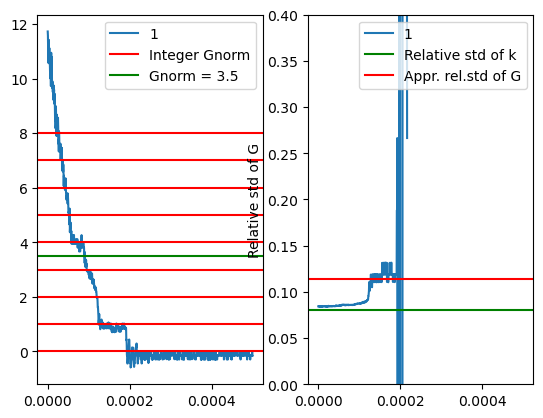

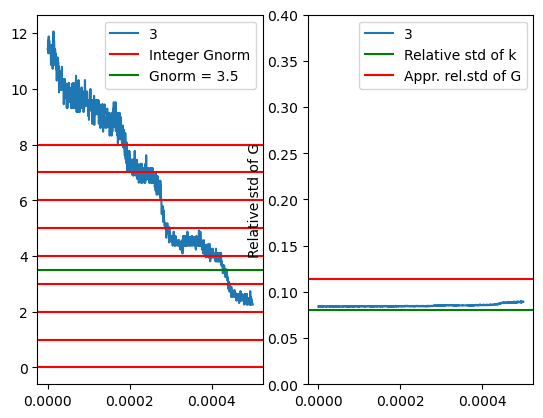

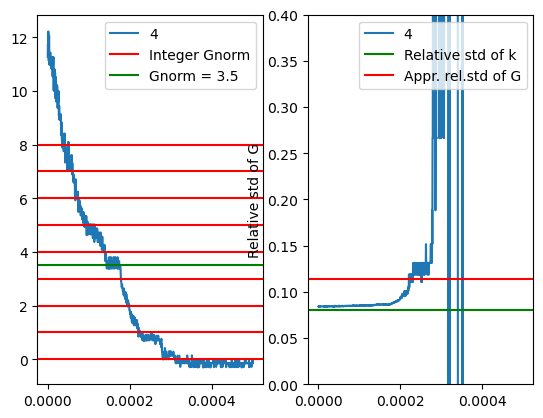

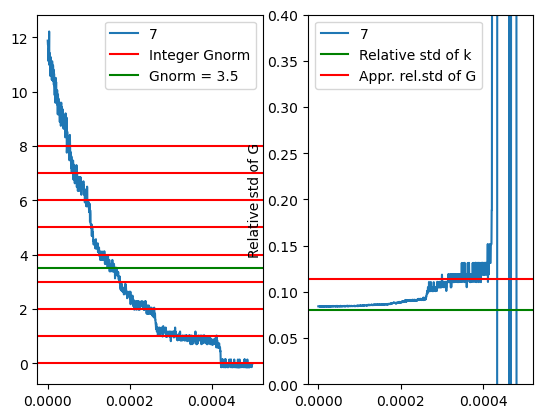

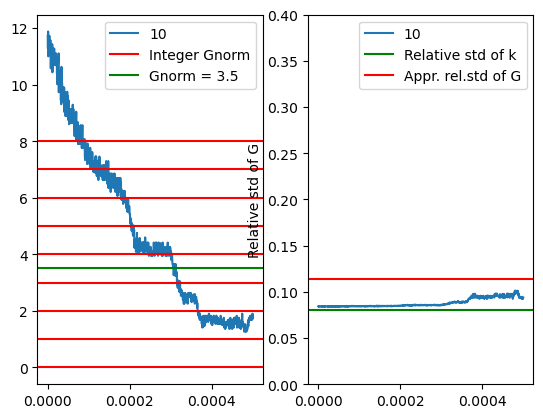

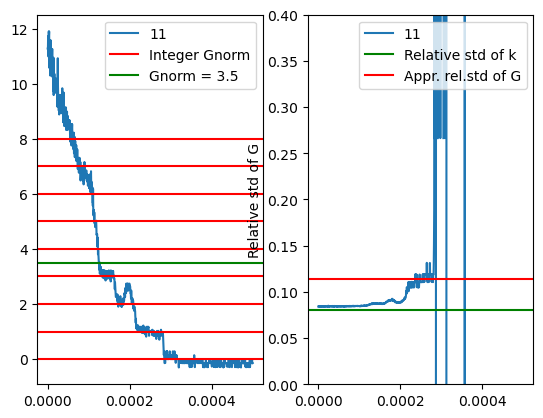

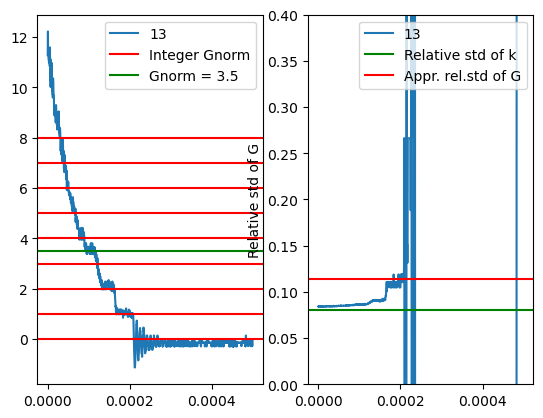

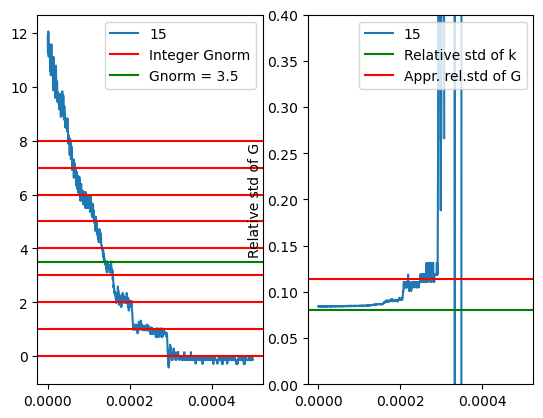

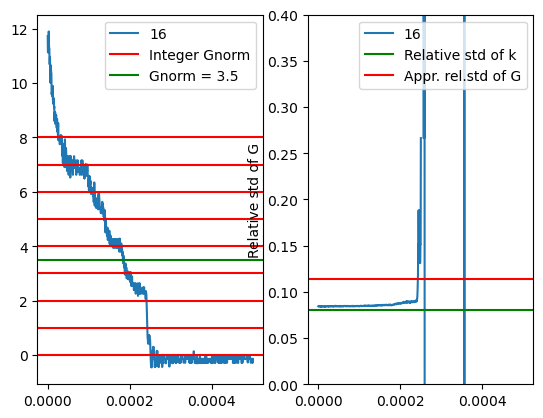

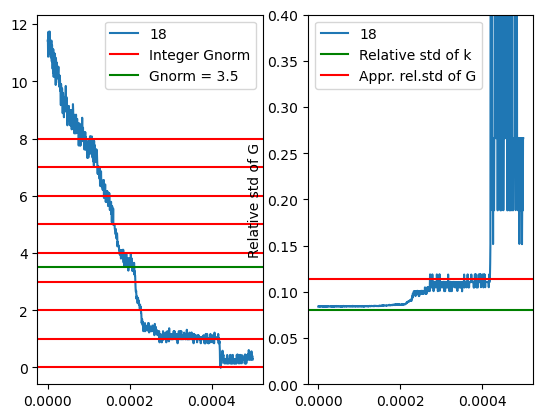

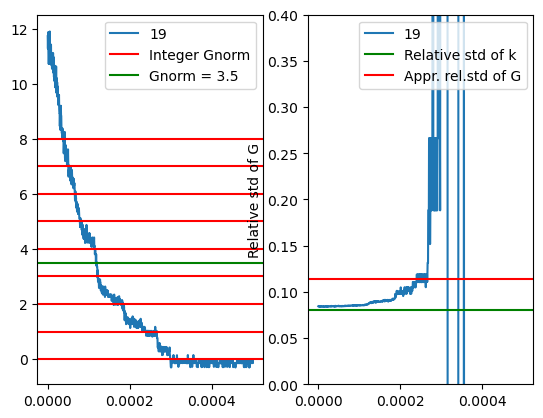

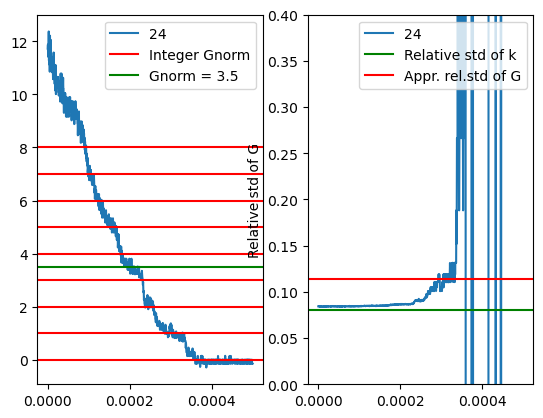

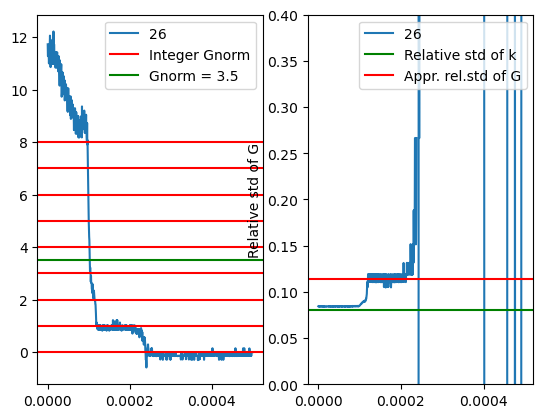

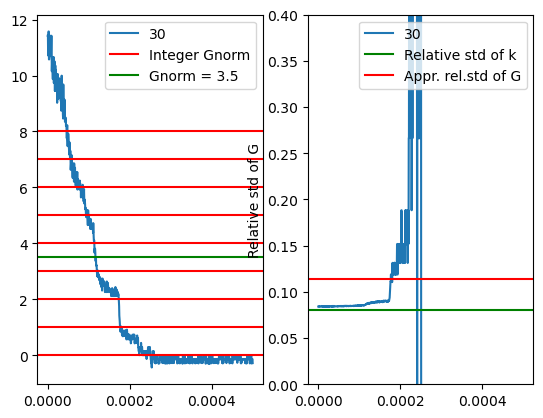

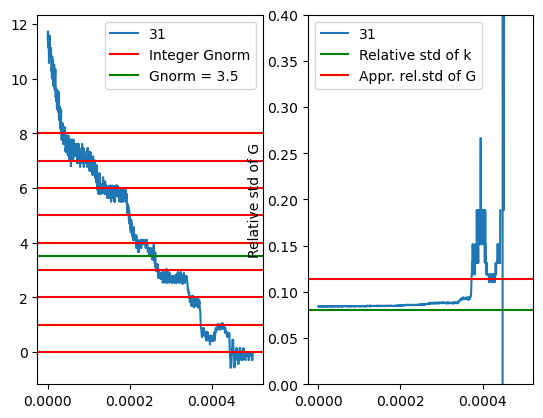

In [45]:
e = 1.602176634e-19
h = 6.62607015e-34

G0 = 2*e**2/h

#[17,22, 2,5,6,8,9,12,14,20,21,23,25,27,28,29,32]

data = np.array([])
num = (num for num in range(1,33) if num not in [17,22,2,5,6,8,9,12,14,20,21,23,25,27,28,29,32])
# num=[9]
for i in num:
    ds = pd.read_csv(f"scope_{i}.csv", header=1)
    ds=ds[ds["second"] >= 0]
    ds.columns=["x-axis", "1", "2"]
    
    G = -K_/G0 * ds["2"].astype(float)/ds["1"].astype(float)
    
    # s_vo and s_vout assumed constant (from the previous section). Need to divide by G0
    sG = 1/G0 * np.sqrt( (ds["2"].astype(float)/ds["1"].astype(float))**2 * s_k**2 + (k*ds["2"].astype(float)/(ds["1"].astype(float)**2))**2 * s_v0**2 + (k/ds["1"].astype(float))**2 * s_vout**2)
    rel_sG = sG / G
    
    data = np.append(data, np.array(G))
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(ds["x-axis"].astype(float), G, label=f"{i}")
    for g in range(8):
        ax1.axhline(y=g, color="r")
    ax1.axhline(y=g+1, color="r", label="Integer Gnorm")    
    ax1.axhline(y=3.5, color='g', label="Gnorm = 3.5")
    ax1.legend()
    #if(i ==13):
    #    ax1.title("Quantized conductance steps over time")
    #    ax1.xlabel("Time (us)")
    #    ax1.ylabel("Normalized conductance (Gnorm)")
    #    ax1.savefig("13.png")
        
    ax2.plot(ds["x-axis"].astype(float), rel_sG, label=f"{i}")
    ax2.set_ylabel("Relative std of G")
    ax2.axhline(y=rel_s_k, color="g", label="Relative std of k")
    ax2.axhline(y=rel_s_G, color="r", label="Appr. rel.std of G")
    ax2.legend()
    ax2.set_ylim([0,0.4])
    
    fig.show()
    

# Histograms + attempts to fit Gaussian curves

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 1.77606602e+00 -3.14286551e+03  9.30501010e-01  1.63140428e+00
  7.17528640e+00  6.43396130e-02 -2.39352492e+02 -1.04119668e-01
  1.83889141e+00  5.42934704e+00  4.38009537e+02  5.21853728e+01
  1.09835247e+03  2.65856829e+02  2.09554598e+02] 
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf]


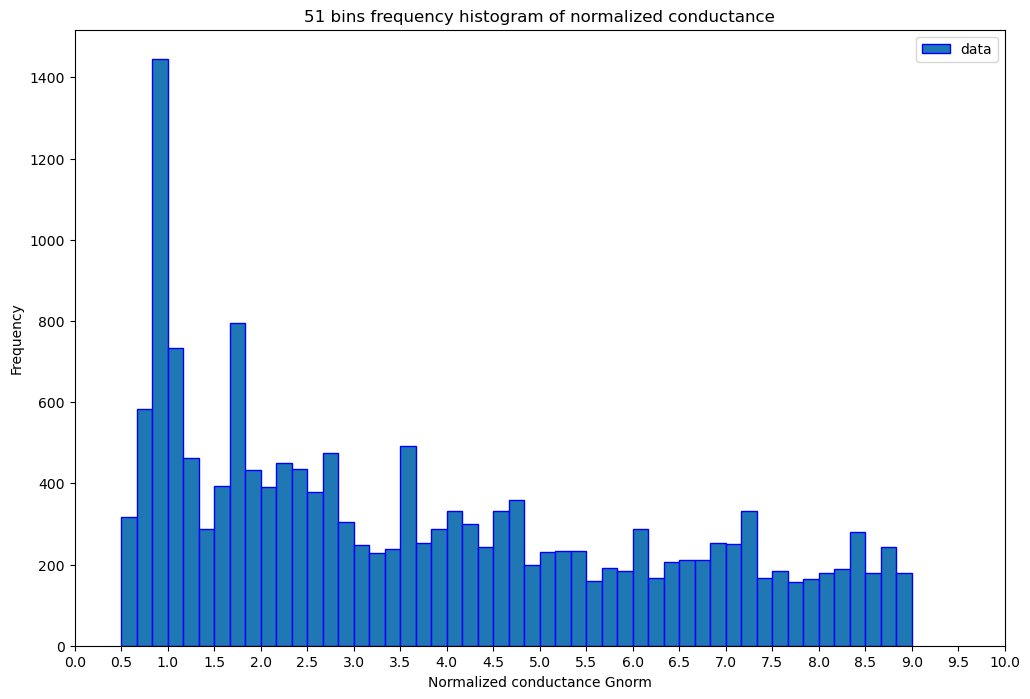

In [4]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def multimodal(x,mu1,mu2,mu3,mu4,mu5,sigma1,sigma2,sigma3,sigma4,sigma5,A1,A2,A3,A4,A5):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)+gauss(x,mu5,sigma5,A5)

fig = plt.figure(figsize=(12,8))

y,x,_= plt.hist(data, bins=51, range=[0.5, 9], edgecolor="b", label="data")
x = 0.5*(x[1:]+ x[:-1])

expected=(1,1,1,
          2,1,1,
          3,1,1,
          3.5,1,0.1,
          4,1,0.1)
params,cov=curve_fit(multimodal,x,y,expected, maxfev=200000)
sigma=np.sqrt(np.diag(cov))
print(params,'\n',sigma)

# plt.plot(x,multimodal(x,*params),color='red',lw=3,label='model')
plt.xticks(np.linspace(0,10,21))
plt.legend()
plt.xlabel("Normalized conductance Gnorm")
plt.ylabel("Frequency")
plt.title("51 bins frequency histogram of normalized conductance")
plt.savefig("hist51.png")
plt.show()

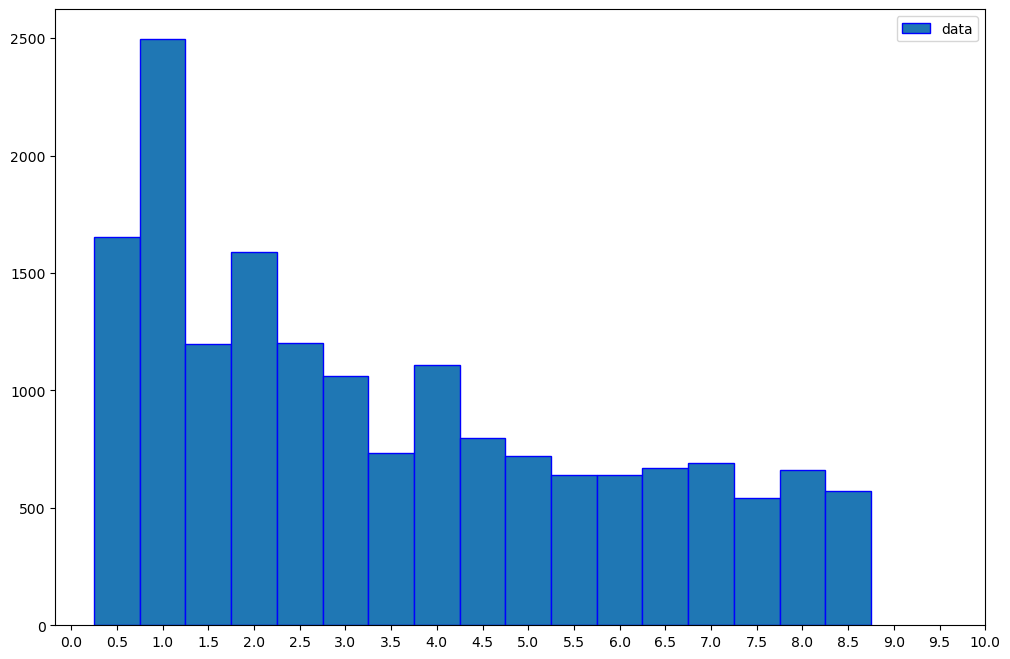

In [7]:
fig = plt.figure(figsize=(12,8))


plt.hist(data, bins=np.linspace(0.25,8.75,18), range=[0.25,8.75], edgecolor="b", label="data")
plt.xticks(np.linspace(0,10,21))
plt.legend()
plt.show()